In [2]:
from __future__ import print_function, division

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Input, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image
from keras.utils import plot_model
from numpy import random

import matplotlib.pyplot as plt
import numpy as np
import sys
import os as os

In [3]:
noise_shape = 100
nh = 64
nw = 64
nc = 3
img_shape = (nh, nw, nc)

# Carefully chosen parameters 
d_opt = Adam(lr = 0.0002, beta_1 = 0.5)
g_opt = Adam(lr = 0.0002, beta_1 = 0.5)

In [4]:
def build_generator():
  
  model = Sequential()
  model.add(Dense(128 * 4 * 4, input_dim = noise_shape, name = 'Dense_Layer'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_Dense'))
  model.add(Reshape((4, 4, 128) , name = "Reshape_Layer"))
  
  #
  model.add(Conv2D(128, kernel_size=3,  padding="same", name = "Conv_Layer"))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU'))
  model.add(BatchNormalization(momentum=0.8, name = "Batch_Norm"))
  #
  
  model.add(UpSampling2D(name = 'UpSampling_Layer_2'))
  model.add(Conv2D(64, kernel_size=3,  padding="same", name = "Conv_Layer_2"))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_2'))
  model.add(BatchNormalization(momentum=0.8, name = "Batch_Norm_2"))
  
  model.add(UpSampling2D(name = 'UpSampling_Layer_3'))
  model.add(Conv2D(32, kernel_size=3, padding="same", name = 'Conv_Layer_3'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_3'))
  model.add(BatchNormalization(momentum=0.8, name = 'Batch_Norm_3'))
  
  model.add(UpSampling2D(name = 'UpSampling_Layer_4'))
  model.add(Conv2D(16, kernel_size=3, padding="same", name = 'Conv_Layer_4'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_4'))
  model.add(BatchNormalization(momentum=0.8, name = 'Batch_Norm_4'))
  
  model.add(UpSampling2D(name = 'UpSampling_Layer_5'))
  model.add(Conv2D(8, kernel_size=3, padding="same", name = 'Conv_Layer_5'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_5'))
  model.add(BatchNormalization(momentum=0.8, name = 'Batch_Norm_5'))
  
  model.add(Conv2D(4, kernel_size=3, padding="same", name = 'Conv_Layer_6'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_6'))
  model.add(BatchNormalization(momentum=0.8, name = 'Batch_Norm_6'))
  
  model.add(Conv2D(3, kernel_size=3, padding="same", name = 'Conv_Layer_7'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_7'))
  model.add(BatchNormalization(momentum=0.8, name = 'Batch_Norm_7'))
  model.add(Activation("tanh"))
   
  print(model.summary())
  
  #Picturizing model
  plot_model(model, to_file='Model Architecture images_deeper_network_with_noise_in_real_and_fake_labels/generator.png')
  
  noise = Input(shape = (noise_shape,))
  img = model(noise)
  
  return Model(inputs = noise, outputs = img, name = "Generator")
  

In [5]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 2048)              206848    
_________________________________________________________________
Leaky_ReLU_Dense (LeakyReLU) (None, 2048)              0         
_________________________________________________________________
Reshape_Layer (Reshape)      (None, 4, 4, 128)         0         
_________________________________________________________________
Conv_Layer (Conv2D)          (None, 4, 4, 128)         147584    
_________________________________________________________________
Leaky_ReLU (LeakyReLU)       (None, 4, 4, 128)         0         
_________________________________________________________________
Batch_Norm (BatchNormalizati (None, 4, 4, 128)         512       
_________________________________________________________________
UpSampling_Layer_2 (UpSampli (None, 8, 8, 128)         0

In [6]:
def build_discriminator():
  model = Sequential()
  
  model.add(Conv2D(4, kernel_size=3, input_shape = img_shape, padding="same", name = 'Conv_Layer'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU'))
  model.add(BatchNormalization(momentum=0.8, name = 'Batch_Norm'))
  
  model.add(Conv2D(8, kernel_size=3, strides = 2, name = 'Conv_Layer_2'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_2'))
  model.add(BatchNormalization(momentum=0.8, name = 'Batch_Norm_2'))
  
  model.add(Conv2D(16, kernel_size=3, strides = 2, name = 'Conv_Layer_3'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_3'))
  model.add(BatchNormalization(momentum=0.8, name = 'Batch_Norm_3'))
  
  model.add(Conv2D(32, kernel_size=3, strides = 2, name = 'Conv_Layer_4'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_4'))
  model.add(BatchNormalization(momentum=0.8, name = 'Batch_Norm_4'))
  
  model.add(Conv2D(64, kernel_size=2, strides = 1, name = 'Conv_Layer_5'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_5'))
  model.add(BatchNormalization(momentum=0.8, name = 'Batch_Norm_5'))
  
  #
  model.add(Conv2D(128, kernel_size=2, strides = 1, name = 'Conv_Layer_6'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_6'))
  model.add(BatchNormalization(momentum=0.8, name = 'Batch_Norm_6'))
  #
  
  model.add(Flatten(name = 'Flatten'))
  model.add(Dense(512, name = 'Dense_Layer'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_7'))
  
  model.add(Dense(256, name = 'Dense_Layer_2'))
  model.add(LeakyReLU(alpha=0.2, name = 'Leaky_ReLU_8'))
  model.add(Dense(1, activation='sigmoid', name = 'Dense_with_Sigmoid'))
  
  print(model.summary())
  
  #Picturizing model
  plot_model(model, to_file='Model Architecture images_deeper_network_with_noise_in_real_and_fake_labels/discriminator.png')
  
  img = Input(shape = img_shape)
  validity = model(img)
  
  return Model(inputs = img, outputs = validity, name = 'Discriminator')

In [7]:
discriminator = build_discriminator()
discriminator.summary()

discriminator.compile(loss = 'binary_crossentropy', optimizer = d_opt, metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_Layer (Conv2D)          (None, 64, 64, 4)         112       
_________________________________________________________________
Leaky_ReLU (LeakyReLU)       (None, 64, 64, 4)         0         
_________________________________________________________________
Batch_Norm (BatchNormalizati (None, 64, 64, 4)         16        
_________________________________________________________________
Conv_Layer_2 (Conv2D)        (None, 31, 31, 8)         296       
_________________________________________________________________
Leaky_ReLU_2 (LeakyReLU)     (None, 31, 31, 8)         0         
_________________________________________________________________
Batch_Norm_2 (BatchNormaliza (None, 31, 31, 8)         32        
_________________________________________________________________
Conv_Layer_3 (Conv2D)        (None, 15, 15, 16)       

In [8]:
z = Input(shape = (noise_shape,), name = "Input_Noise")
img = generator(z)

discriminator.trainable = False
valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss = 'binary_crossentropy', optimizer = g_opt)
combined.summary()

#Picturizing model
plot_model(combined, to_file='Model Architecture images_deeper_network_with_noise_in_real_and_fake_labels/combined.png')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Noise (InputLayer)     [(None, 100)]             0         
_________________________________________________________________
Generator (Functional)       (None, 64, 64, 3)         453895    
_________________________________________________________________
Discriminator (Functional)   (None, 1)                 1818873   
Total params: 2,272,768
Trainable params: 453,385
Non-trainable params: 1,819,383
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [9]:
print(generator.summary())
print(discriminator.summary())
print(combined.summary())

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 3)         453895    
Total params: 453,895
Trainable params: 453,385
Non-trainable params: 510
_________________________________________________________________
None
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1818873   
Total params: 1,818,873
Trainable params: 0
Non-trainable params: 1,818,873
_________________________________________________________________
None
Model:

In [10]:
def get_batch(width, height):
  image_files = os.listdir("C:\\Users\\Tushar\\Downloads\\DCGAN\\content\\100k\\")[:]
  data_batch = []
  
  for file in image_files:
    img = Image.open("C:\\Users\\Tushar\\Downloads\\DCGAN\\content\\100k\\"+file).resize([width, height])
    data_batch.append(np.array(img.convert('RGB')))
    
  data_batch = np.array(data_batch)
  print(data_batch.shape)
  return data_batch

In [11]:
g_losses = []
d_losses = []

In [12]:
def train(batch_size = 128, epochs = 15830):
  
  
  valid = np.ones((batch_size, 1))
  fakes = np.ones((batch_size, 1))
  
  X_train = get_batch(nw, nh)
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  
  for epoch in range(epochs):
    
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    
    noise = np.random.normal(0, 1, (batch_size, noise_shape))
    
    gen_imgs = generator.predict(noise)

    #Training Discriminator
    d_loss_real = discriminator.train_on_batch(imgs, valid*random.uniform(0.9, 1.0))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fakes*random.uniform(0.0, 0.1))
    d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

    #Training Generator
    g_loss = combined.train_on_batch(noise, valid)

    #Progress
    if (epoch+1)%50 == 0:
      print("epoch: " + str(epoch+1) + " " + "D_Loss = " + str(d_loss[0]) + " " + "acc: " + str(d_loss[1]*100) + " " +  "G_Loss = " + str(g_loss))
    
    if (epoch+1)%10000 == 0 or epoch+1 == 1000:
      save_imgs(epoch+1)
    g_losses.append(float(d_loss[0]))
    d_losses.append(float(g_loss))

In [11]:
!mkdir 'images_deeper_network_with_noise_in_real_and_fake_labels'

In [13]:
def save_imgs(epoch):
  r, c = 3, 3
  noise = np.random.normal(0, 1, (r * c, noise_shape))
  gen_imgs = generator.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = (1/2.5) * gen_imgs + 0.5
  
  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,:])
          axs[i,j].axis('off')
          cnt += 1
  fig.savefig("images_deeper_network_with_noise_in_real_and_fake_labels/%d.png" % epoch)
  plt.close()

In [13]:
train(128, 1000)

(100000, 64, 64, 3)
epoch: 50 D_Loss = 0.3442038893699646 acc: 0.0 G_Loss = 1.8165526390075684
epoch: 100 D_Loss = 0.3578792214393616 acc: 0.0 G_Loss = 1.581268310546875
epoch: 150 D_Loss = 0.19862773269414902 acc: 0.0 G_Loss = 1.4289790391921997
epoch: 200 D_Loss = 0.2154974564909935 acc: 0.0 G_Loss = 0.9770841002464294
epoch: 250 D_Loss = 0.1958714947104454 acc: 0.0 G_Loss = 0.6383459568023682
epoch: 300 D_Loss = 0.17847231030464172 acc: 0.0 G_Loss = 0.45856183767318726
epoch: 350 D_Loss = 0.2186966985464096 acc: 0.0 G_Loss = 0.33748966455459595
epoch: 400 D_Loss = 0.2913261204957962 acc: 0.0 G_Loss = 0.25105154514312744
epoch: 450 D_Loss = 0.16141875088214874 acc: 0.0 G_Loss = 0.12336955964565277
epoch: 500 D_Loss = 0.11944201774895191 acc: 0.0 G_Loss = 0.09506496042013168
epoch: 550 D_Loss = 0.24769451469182968 acc: 0.0 G_Loss = 0.04023563861846924
epoch: 600 D_Loss = 0.2911573722958565 acc: 0.0 G_Loss = 0.05202091485261917
epoch: 650 D_Loss = 0.2437000647187233 acc: 0.0 G_Loss = 0

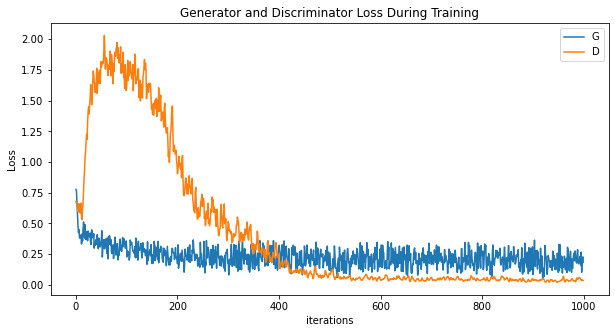

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
generator.save_weights('generator3.h5')
discriminator.save_weights('discriminator3.h5')

# Generating Images

In [14]:
generator.load_weights('generator3.h5')
discriminator.load_weights('discriminator3.h5')

In [21]:
save_imgs(100)